In [1]:
import gzip, struct
import numpy as np


def _read(image,label):
    minist_dir = './data/'
    with gzip.open(minist_dir + label) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.frombuffer(flbl.read(), dtype=np.int8)
    with gzip.open(minist_dir + image, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.frombuffer(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return image, label

def get_data():
    train_img, train_label = _read(
            'train-images-idx3-ubyte.gz',
            'train-labels-idx1-ubyte.gz')
    test_img, test_label = _read(
            't10k-images-idx3-ubyte.gz', 
            't10k-labels-idx1-ubyte.gz')
    return [train_img, train_label, test_img, test_label]

X, y, Xt, yt = get_data()

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms


batch_size = 256

train_x, train_y = [ torch.from_numpy(X.reshape(-1, 1, 28, 28)).float(), 
    torch.from_numpy(y.astype(int)) ]
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset=train_dataset, shuffle=True, 
                          batch_size=batch_size, num_workers=2, pin_memory=True)

test_x, test_y = [ torch.from_numpy(Xt.reshape(-1, 1, 28, 28)).float(),
    torch.from_numpy(yt.astype(int)) ]
test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(dataset=test_dataset, shuffle=True,
                         batch_size=batch_size, num_workers=2, pin_memory=True)

Using device: cuda:0


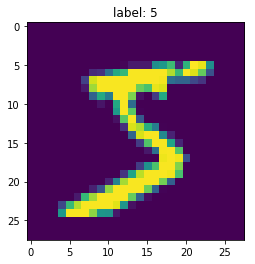

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img, label):
    plt.imshow(img.reshape((28, 28)))
    plt.title('label: ' + str(label))

imshow(X[0], y[0])

In [4]:
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = LeNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

net.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.99))

def weight_init(m):
    if isinstance(m, nn.Conv2d):
        import math
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()

net.apply(weight_init)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
def train(epoch):
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = net(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        # print statistics
        if batch_idx % 90 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.0 * batch_idx / len(train_loader), loss.item()))
def test():
    net.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = net(data)
            # sum up batch loss
            test_loss += criterion(output, label).data.item()
            # get the index of the max log-probability
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(label.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100.0 * correct / len(test_loader.dataset)))

for epoch in range(10):
    train(epoch)
    test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.181253
Train Epoch: 0 [23040/60000 (38%)]	Loss: 1.261541
Train Epoch: 0 [46080/60000 (77%)]	Loss: 0.172843

Test set: Average loss: 0.0589, Accuracy: 9881/10000 (98.00%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.058668
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.033376
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.137616

Test set: Average loss: 0.0721, Accuracy: 9859/10000 (98.00%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.061060
Train Epoch: 2 [23040/60000 (38%)]	Loss: 0.158294
Train Epoch: 2 [46080/60000 (77%)]	Loss: 2.105832

Test set: Average loss: 0.0561, Accuracy: 9891/10000 (98.00%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 4.312164
Train Epoch: 3 [23040/60000 (38%)]	Loss: 0.165908
Train Epoch: 3 [46080/60000 (77%)]	Loss: 5.161349

Test set: Average loss: 0.0611, Accuracy: 9895/10000 (98.00%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.023689
Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.193771
Train Epoch: 4 [46080/60000 (77%)]	Loss: 5.748004

Test set: Average 